In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pyrepseq as prs
from pyrepseq.metric.tcr_metric import TcrMetric
import pandas as pd
import random
from sceptr import variant
from sklearn import metrics
from typing import List

/home/yutanagano/miniconda3/envs/sceptr_publication_analyses/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_data = pd.read_csv("../tcr_data/preprocessed/benchmarking/vdjdb_cleaned.csv")

models = (
    prs.metric.tcr_metric.Tcrdist(),
    variant.ab_sceptr()
)

In [3]:
test_data

,TRAV,CDR3A,TRAJ,TRBV,CDR3B,TRBJ,Epitope,MHCA,MHCB,Epitope_species,Reference
0,TRAV27*01,CAGAGSQGNLIF,TRAJ42*01,TRBV19*01,CASSSRSSYEQYF,TRBJ2-7*01,GILGFVFTL,HLA-A*02:01:48,B2M,InfluenzaA,PMID:12796775
1,TRAV27*01,CAGAGSQGNLIF,TRAJ42*01,TRBV19*01,CASSSRSSYEQYF,TRBJ2-7*01,GILGFVFTL,HLA-A*02:01:48,B2M,InfluenzaA,PMID:18275829
2,TRAV27*01,CAGAGSQGNLIF,TRAJ42*01,TRBV19*01,CASSSRASYEQYF,TRBJ2-7*01,GILGFVFTL,HLA-A*02:01:48,B2M,InfluenzaA,PMID:18275829
3,TRAV24*01,CARNTGNQFYF,TRAJ49*01,TRBV6-5*01,CASSPVTGGIYGYTF,TRBJ1-2*01,NLVPMVATV,HLA-A*02:01:98,B2M,CMV,PMID:19542454
4,TRAV5*01,CAEDNNARLMF,TRAJ31*01,TRBV20-1*01,CSARDGTGNGYTF,TRBJ1-2*01,GLCTLVAML,HLA-A*02:01:48,B2M,EBV,PMID:21124993
...,...,...,...,...,...,...,...,...,...,...,...
3823,TRAV35*01,CAGQLYGGSQGNLIF,TRAJ42*01,TRBV6-2*01,CASSYRQGQPQHF,TRBJ1-5*01,TFEYVSQPFLMDLE,NaN,NaN,SARS-CoV-2,PMID:35750048
3824,TRAV35*01,CAGLNYGGSQGNLIF,TRAJ42*01,TRBV6-6*01,CASRNRQQTLYGYTF,TRBJ1-2*01,TFEYVSQPFLMDLE,NaN,NaN,SARS-CoV-2,PMID:35750048
3825,TRAV35*01,CAGLNYGGSQGNLIF,TRAJ42*01,TRBV5-5*01,CASSWRQGGSIRESYTF,TRBJ1-2*01,TFEYVSQPFLMDLE,NaN,NaN,SARS-CoV-2,PMID:35750048
3826,TRAV35*01,CAALNYGGSQGNLIF,TRAJ42*01,TRBV6-4*01,CASSDRGTGLNGYTF,TRBJ1-2*01,TFEYVSQPFLMDLE,NaN,NaN,SARS-CoV-2,PMID:35750048


In [10]:
epitopes = test_data.Epitope.unique()

def get_benchmark_results(model: TcrMetric) -> dict:
    aucs_per_epitope = dict()

    for epitope in epitopes:
        print(f"Benchmarking for {epitope}...")
        one_shot_aucs = get_one_shot_aucs(model, epitope)
        hundred_shot_aucs = get_few_shot_aucs(model, epitope, 100)
        aucs_per_epitope[epitope] = {
            1: one_shot_aucs,
            100: hundred_shot_aucs
        }
    
    return aucs_per_epitope

def get_one_shot_aucs(model: TcrMetric, epitope: str) -> List[float]:
    test_data_epitope_mask = test_data.Epitope == epitope
    epitope_references = test_data[test_data_epitope_mask]
    cdist_matrix = model.calc_cdist_matrix(epitope_references, test_data)
    similarity_matrix = np.exp(-cdist_matrix/20)

    aucs = []
    for similarity_matrix_idx, tcr_idx in enumerate(epitope_references.index):
        similarities = similarity_matrix[similarity_matrix_idx]

        similarities = np.delete(similarities, tcr_idx)
        ground_truth = np.delete(test_data_epitope_mask, tcr_idx)

        aucs.append(metrics.roc_auc_score(ground_truth, similarities))

    return aucs

def get_few_shot_aucs(model: TcrMetric, epitope: str, num_shots: int) -> List[float]:
    test_data_epitope_mask = test_data.Epitope == epitope
    epitope_references = test_data[test_data_epitope_mask]

    if len(epitope_references)- num_shots < 100:
        return []

    random_subsets = [
        random.sample(epitope_references.index.to_list(), k=num_shots) for _ in range(100)
    ]

    aucs = []
    for subset_indices in random_subsets:
        epitope_reference_subset = epitope_references.loc[subset_indices]
        cdist_matrix = model.calc_cdist_matrix(epitope_reference_subset, test_data)
        similarity_matrix = np.exp(-cdist_matrix/20)
        similarities = np.mean(similarity_matrix, axis=0)

        similarities = np.delete(similarities, subset_indices)
        ground_truth = np.delete(test_data_epitope_mask, subset_indices)

        aucs.append(metrics.roc_auc_score(ground_truth, similarities))
    
    return aucs

In [11]:
benchmarks_per_metric = {
    model.name: get_benchmark_results(model) for model in models
}

Benchmarking for GILGFVFTL...
Benchmarking for NLVPMVATV...
Benchmarking for GLCTLVAML...
Benchmarking for YLQPRTFLL...
Benchmarking for LLWNGPMAV...
Benchmarking for CINGVCWTV...
Benchmarking for QYIKWPWYI...
Benchmarking for TFEYVSQPFLMDLE...
Benchmarking for LTDEMIAQY...
Benchmarking for TTDPSFLGRY...
Benchmarking for SPRWYFYYL...
Benchmarking for KTFPPTEPK...
Benchmarking for GILGFVFTL...


/home/yutanagano/miniconda3/envs/sceptr_publication_analyses/lib/python3.12/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Benchmarking for NLVPMVATV...
Benchmarking for GLCTLVAML...
Benchmarking for YLQPRTFLL...
Benchmarking for LLWNGPMAV...
Benchmarking for CINGVCWTV...
Benchmarking for QYIKWPWYI...
Benchmarking for TFEYVSQPFLMDLE...
Benchmarking for LTDEMIAQY...
Benchmarking for TTDPSFLGRY...
Benchmarking for SPRWYFYYL...
Benchmarking for KTFPPTEPK...


In [12]:
def get_average_aucs(benchmark_dict: dict) -> dict:
    average_aucs_per_epitope = dict()

    for epitope, epitope_aucs in benchmark_dict.items():
        average_aucs = {
            k: np.mean(aucs) for k, aucs in epitope_aucs.items()
        }
        average_aucs_per_epitope[epitope] = average_aucs
    
    return average_aucs_per_epitope

averages_per_model = {
    model: get_average_aucs(benchmark_dict) for model, benchmark_dict in benchmarks_per_metric.items()
}

/home/yutanagano/.local/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yutanagano/.local/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [19]:
few_shot_tcrdist = {epitope: aucs[100] for epitope, aucs in averages_per_model["tcrdist"].items() if not np.isnan(aucs[100])}
few_shot_sceptr = {epitope: aucs[100] for epitope, aucs in averages_per_model["AB SCEPTR"].items() if not np.isnan(aucs[100])}

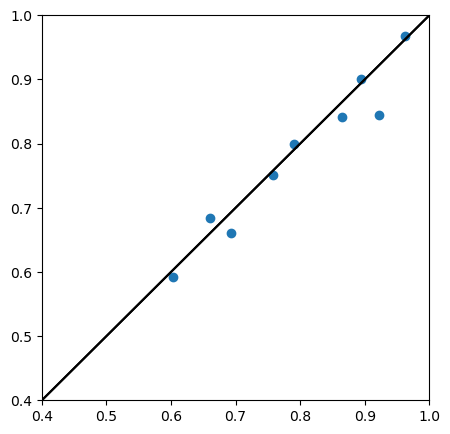

In [20]:
plt.figure(figsize=(5,5))
plt.scatter(few_shot_tcrdist.values(), few_shot_sceptr.values())
plt.plot(((0,0),(1,1)), c="k")
plt.xlim(0.4,1)
plt.ylim(0.4,1)
plt.show()